# Music Valence Prediction

Spotify data | Tensorflow Keras | Convolutional Neural Network

***

## Project descritption

### The problem

The main task of this project is to develop a python-based module to predict valence of newly released pop songs.   

*Valence* is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

### The dataset

In this version of the project, Spotify data will be used: audio features and 30-second audio previews, available with the `spotify` library.

### Audio features

The approach of the following research paper will be implemented: [Music Mood Classification using Convolutional Neural Networks](https://ccrma.stanford.edu/~jansto/documents/EmotionRecognition_Paper.pdf), with Mel-Spectrogram as the only audio feature being used.

### Music attributes

In addition, the most related to this task music attributes will be explored:

- *Tempo:* The tempo of the song. The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, the tempo is the speed or pace of a given piece and derives directly from the average beat duration.  

- *Energy:* a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. Higher the value more energetic the song.

- *Danceability:* describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. The value ranges from 0 to 1. Higher the value more suitable the song is for dancing.

- *Loudness:* Loudness values are averaged across the entire track. It is the quality of a song. It ranges from -60 to 0 DB. Higher the value, the louder the song.

**the attributes description is taken from the article on Medium: [Spotify Music Data Analysis: Part 3](https://medium.com/analytics-vidhya/spotify-music-data-analysis-part-3-9097829df16e)*

***

## Imports and settings

In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display as lib_display
import IPython.display as ipy_display

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import L1L2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_style("dark", {"axes.facecolor":"0.95"})
sns.set_palette("cubehelix")

plt.rcParams["figure.figsize"] = (9, 4)
%config InlineBackend.figure_format = "retina"

In [88]:
seed = 490276

***

## EDA

### Read the data

In [106]:
data = pd.read_csv("spotify_data/songs_data.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   artist           6800 non-null   object 
 1   artist_uri       6800 non-null   object 
 2   track_name       6800 non-null   object 
 3   track_id         6800 non-null   object 
 4   track_uri        6800 non-null   object 
 5   preview_url      6800 non-null   object 
 6   tempo            6800 non-null   float64
 7   energy           6800 non-null   float64
 8   danceability     6800 non-null   float64
 9   loudness         6800 non-null   float64
 10  valence          6800 non-null   float64
 11  local_file_path  6800 non-null   object 
dtypes: float64(5), object(7)
memory usage: 637.6+ KB


### Features relation

Look at how the features of music (attributes) are related to each other.

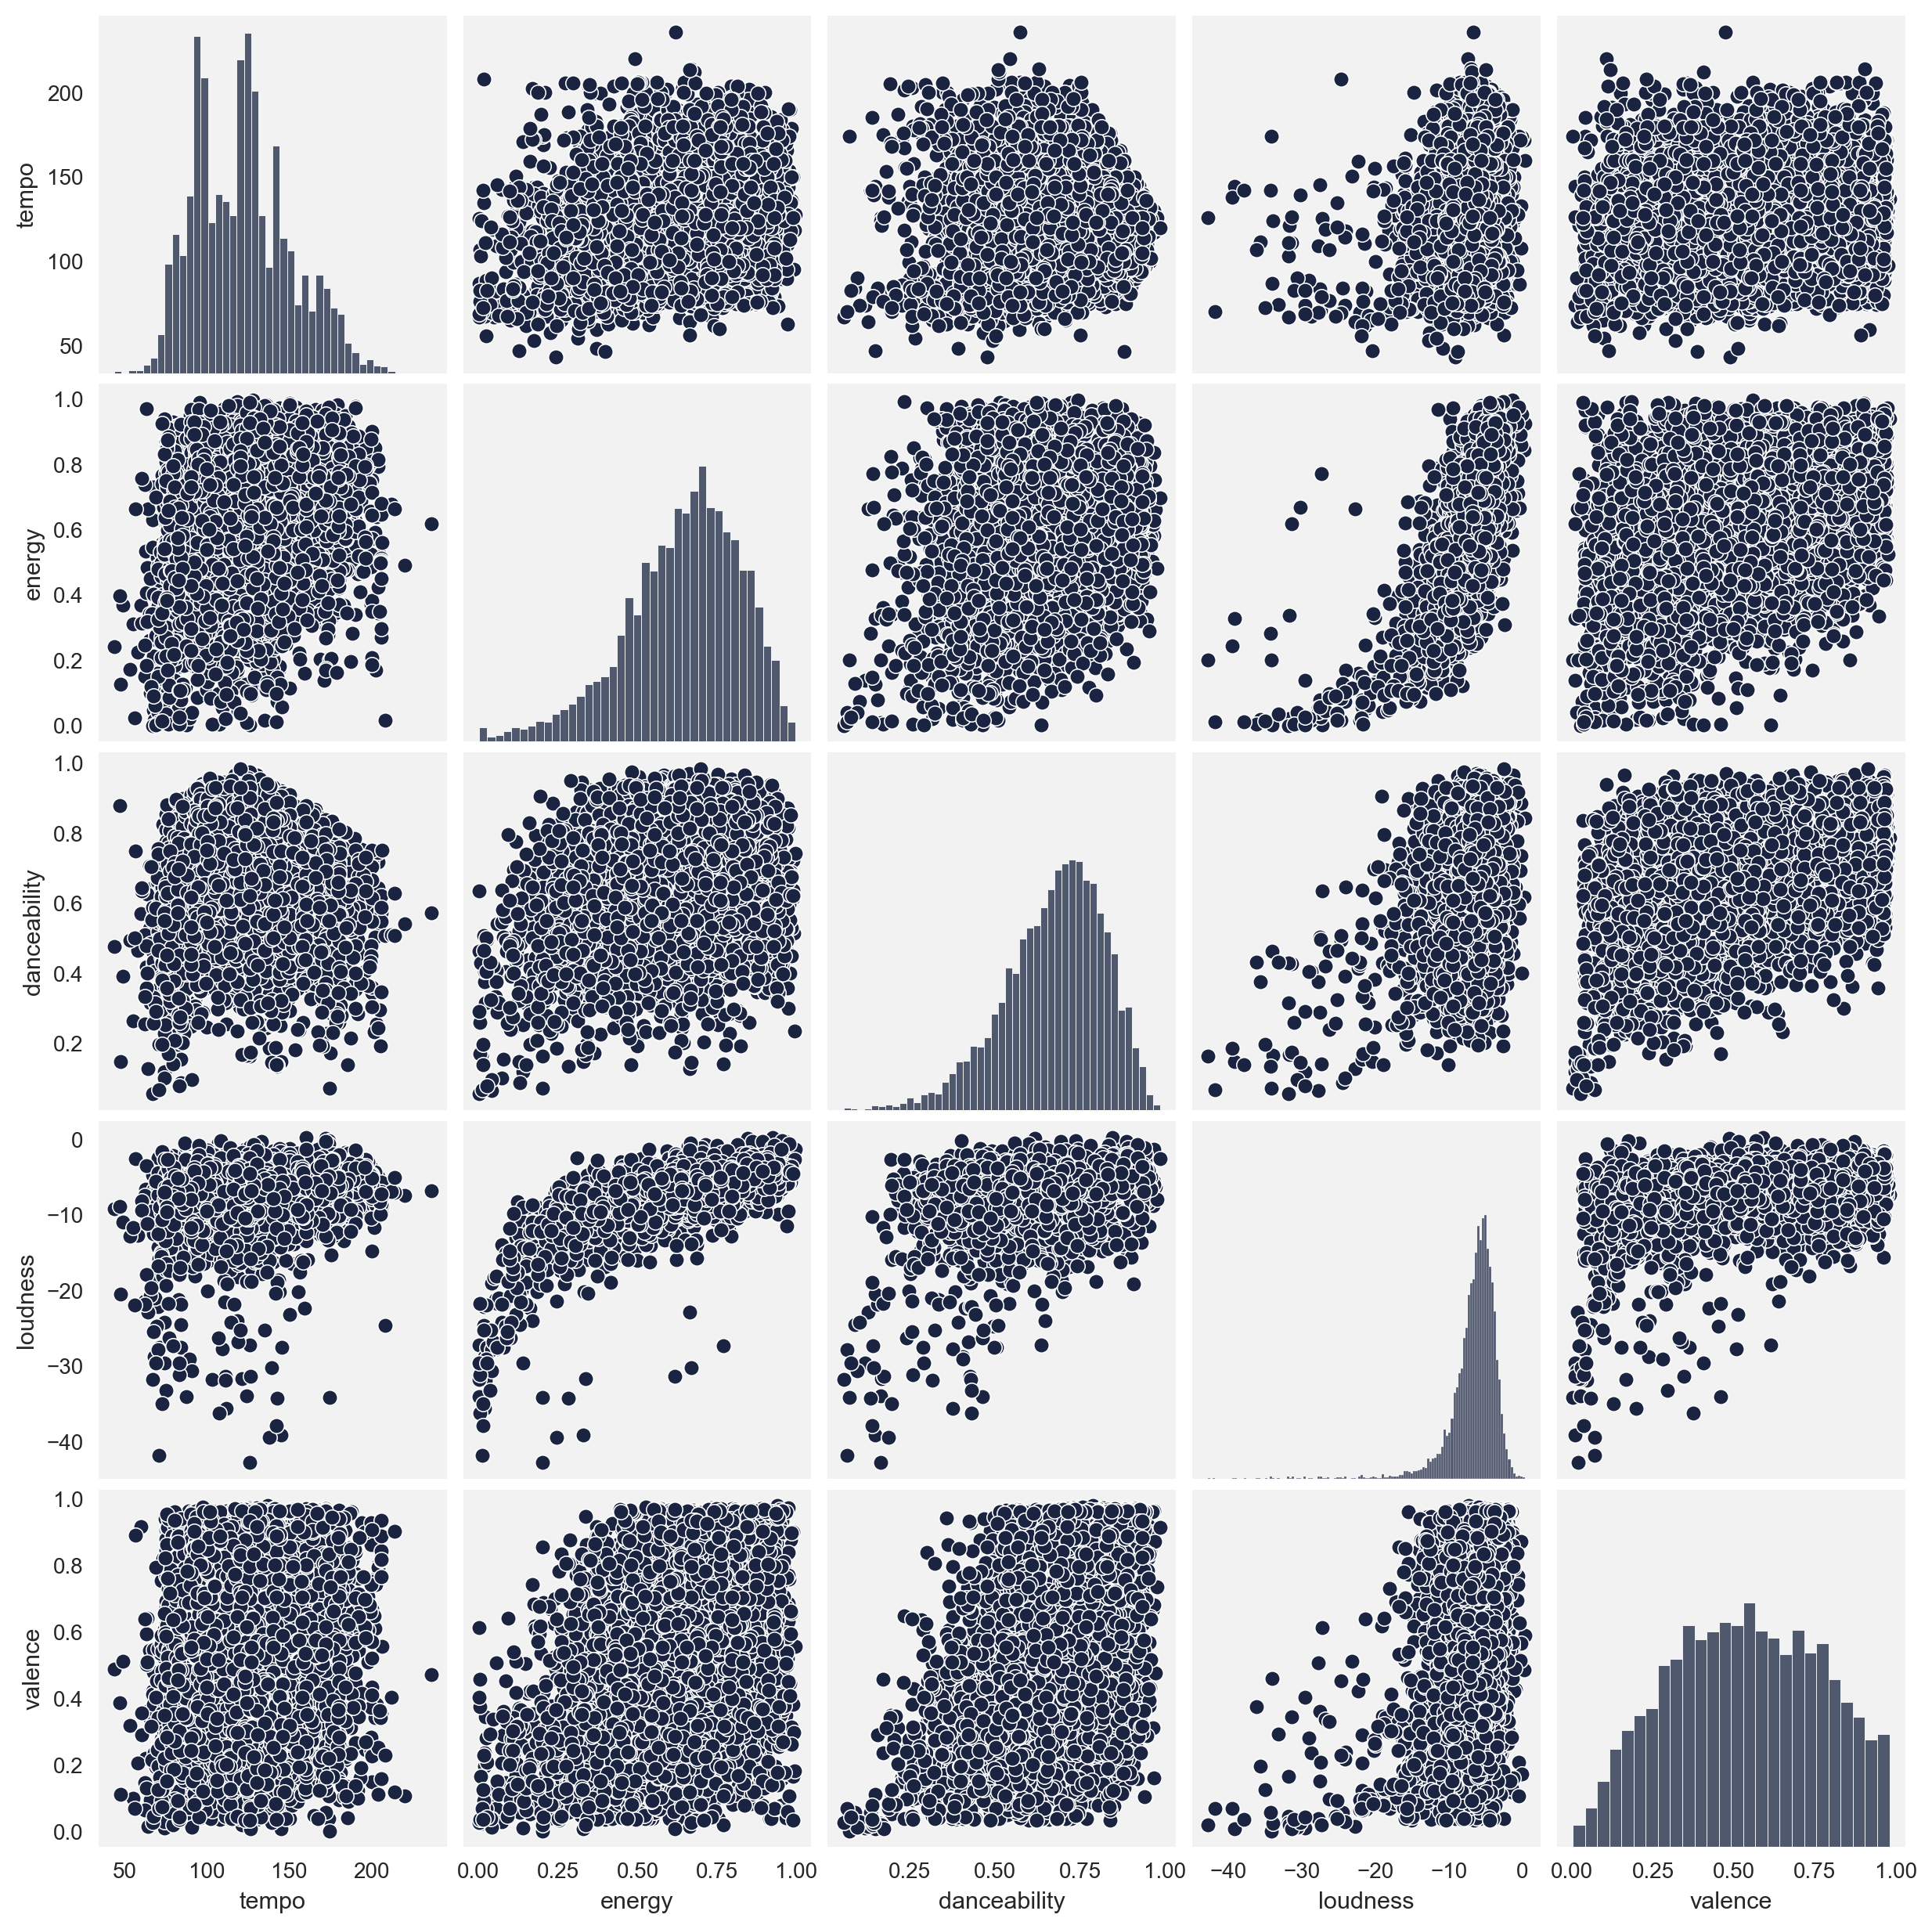

In [7]:
atr_cols = ["tempo","energy","danceability","loudness","valence"]
sns.pairplot(data[atr_cols]);

All feature values have a natural, normal distribution. Some features seem to be correlated, but it's difficult to say from the scatter plots.

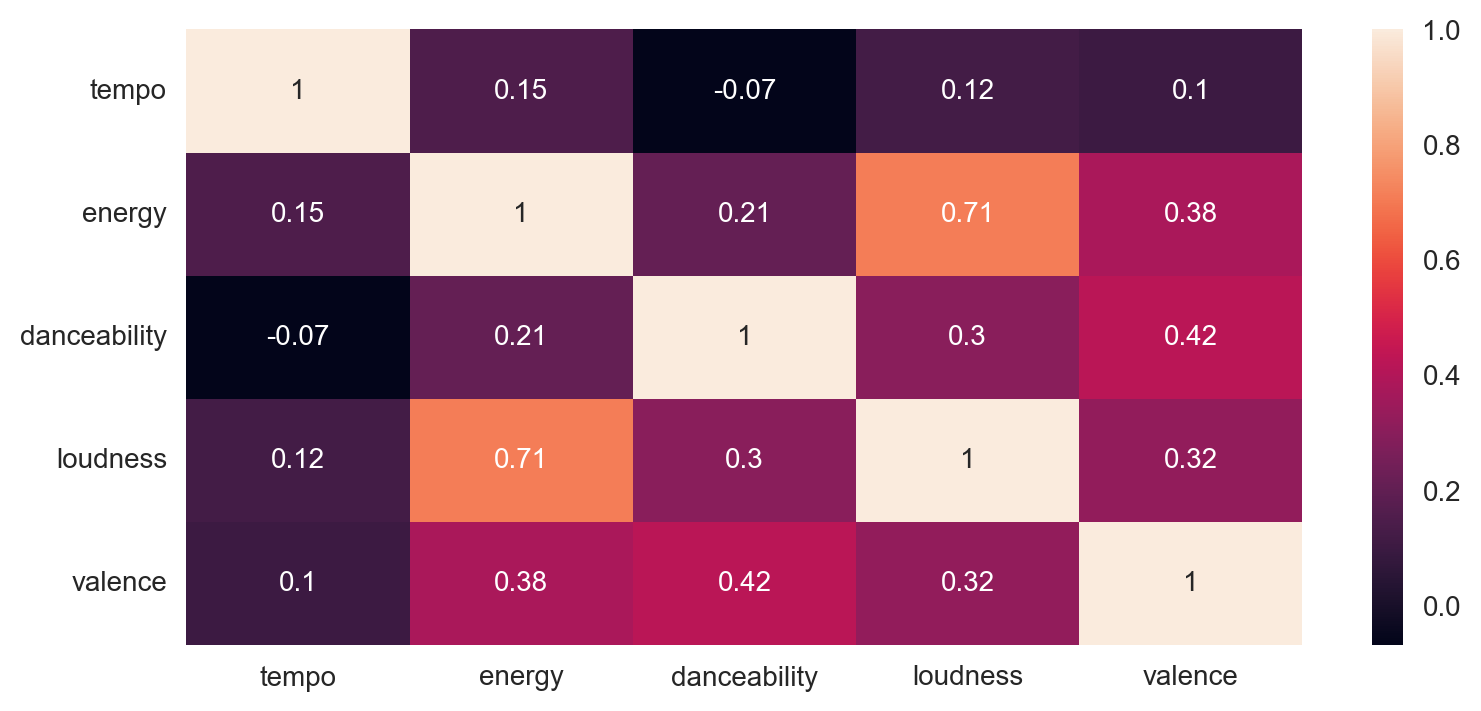

In [8]:
corr_matrix = data[atr_cols].corr().round(2)
sns.heatmap(corr_matrix, annot=True);

The target feature, *valence*, is most correlated with with *danceability* and *energy*, although not significant enough to derive one from the other. The most correlated features are *loudness* and *energy*.

### Genres

<mark>TBD...</mark>

***

## Features Extraction

The audio files need to be converted to mono and then resampled with a Sampling Frequency fs = 16000 Hz to save computing time. 

### Procedure

Estimated valence:  0.169


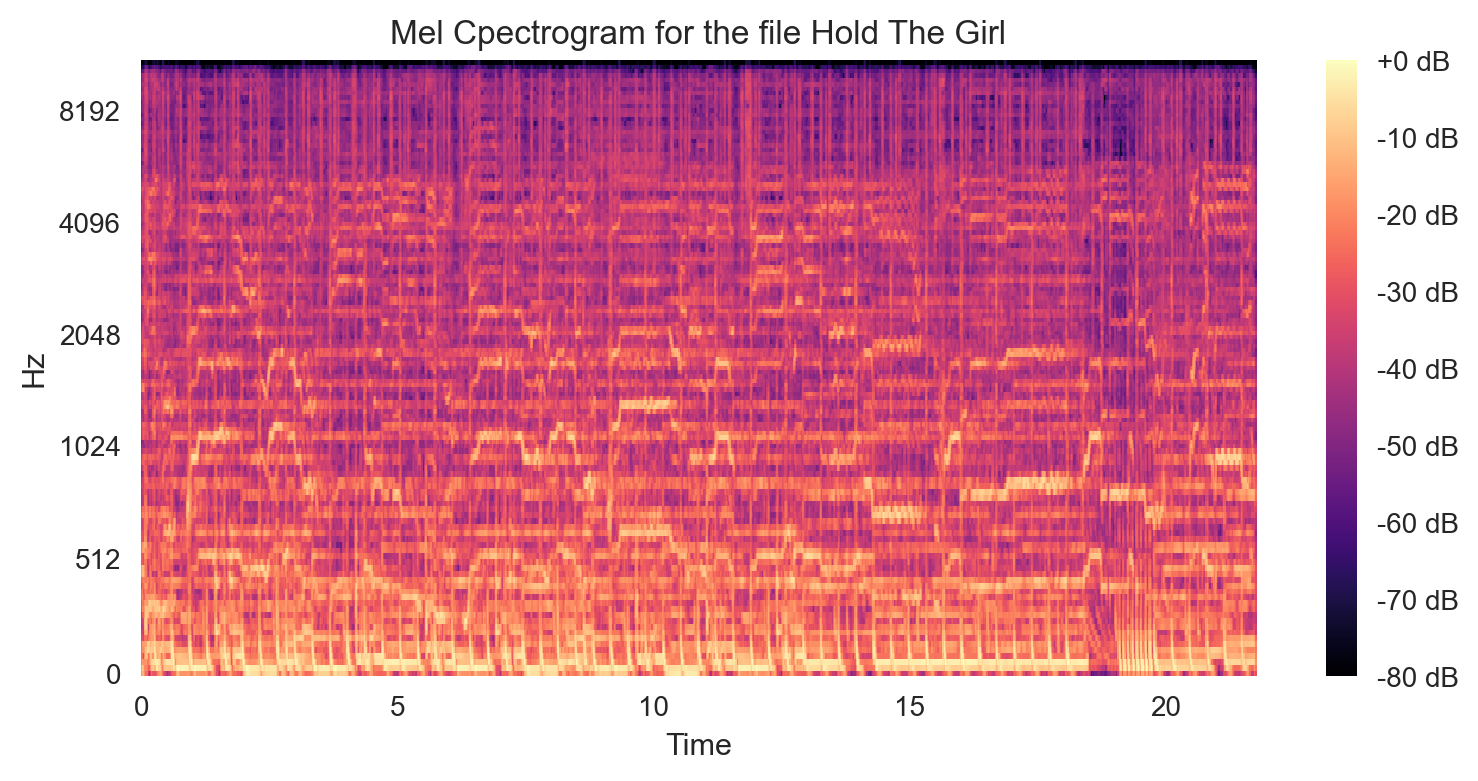

In [85]:
# select an arbitrary song from the dataset
rand_idx = np.random.randint(0, data.shape[0])
arb_song = data.loc[rand_idx,:]
file_path = arb_song["local_file_path"]

# load the audio file and resample
y, sr = librosa.load(file_path)
y = librosa.resample(y, orig_sr=sr, target_sr=16000)

# obtain melspectogram with 128 freq. bins
mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=128)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

# show the resulting spectogram
librosa.display.specshow(mel_spec, y_axis='mel', x_axis='time')
plt.title("Mel Cpectrogram for the file {}".format(arb_song["track_name"]));
plt.colorbar(format='%+2.0f dB');

print("Estimated valence: ", arb_song["valence"])
ipy_display.Audio(file_path)

### Extract features

In [59]:
# features = []

# for i in tqdm(range(data.shape[0])):
    
#     track_id = data.loc[i, "track_id"]
#     file_path = data.loc[i,"local_file_path"]

#     # load the audio file and resample
#     y, sr = librosa.load(file_path, duration=25)
#     y = librosa.resample(y, orig_sr=sr, target_sr=16000)
    
#     # normalize from -1 to 1
#     y = librosa.util.normalize(y)

#     # obtain melspectogram with 128 freq. bins
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=128)
#     mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
#     # save extracted feature to the local directory
#     np.savetxt("spotify_data/mel_spec_features/" + track_id + ".csv",
#                mel_spec, delimiter=",")
    
#     # append to the features list
#     features.append(mel_spec)

100%|█████████████████████████████████████| 6800/6800 [1:18:25<00:00,  1.45it/s]


In [17]:
# load fetures
features = []

for i in tqdm(range(data.shape[0])):
    track_id = data.loc[i, "track_id"]
    feature = pd.read_csv(
        "spotify_data/mel_spec_features/" + track_id + ".csv", 
        index_col=0).values
    
    features.append(feature)

In [86]:
# convert to an array
features = np.array(features)
features.shape

(6800, 128, 782)

### Split the data

In [107]:
# bring the valence values on the scale from 0 to 10
data["valence"] = (data["valence"] * 10).round(2)

In [108]:
X = features
y = data["valence"].values

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.1, 
                                          random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.2,
                                                      random_state=seed)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(4896, 128, 782)
(1224, 128, 782)
(680, 128, 782)


***

## Model training

In [141]:
model = Sequential()
optimizer = Adam(learning_rate=0.001)
regularizer = L1L2(l1=0.001, l2=0.01)

model.add(Conv2D(filters=16, kernel_size=(3,3),
                 input_shape=(128, 782, 1), activation="relu"))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(8, activation="relu", kernel_regularizer=regularizer))
model.add(BatchNormalization())
model.add(Dropout(.1))
model.add(Dense(1))

model.compile(
    loss="mean_squared_error",
    metrics=["mean_absolute_error"],
    optimizer=optimizer
)

In [143]:
checkpoints = ModelCheckpoint(filepath=f"saved_models/spotify_6800songs.hdf5",
                              verbose=1, save_best_only=True)

# initialize callbacks
earlystop = EarlyStopping(patience=10)
learn_rate_reduce = ReduceLROnPlateau(monitor="val_mean_absolute_error",
                                     patience=5,
                                     verbose=1,
                                     factor=.5,
                                     min_lr=.00001)

In [144]:
# fit the model
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    # batch_size=batch_size,
    callbacks=[checkpoints, earlystop, learn_rate_reduce],
    verbose=1
)

Epoch 1/50


2023-01-01 11:08:37.933593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


152/153 [============================>.] - ETA: 0s - loss: 32.5449 - mean_absolute_error: 4.9171

2023-01-01 11:08:46.468810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 21.93672, saving model to saved_models/spotify_6800songs.hdf5
153/153 [==============================] - 10s 58ms/step - loss: 32.4864 - mean_absolute_error: 4.9115 - val_loss: 21.9367 - val_mean_absolute_error: 3.7805 - lr: 0.0010
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 21.5590 - mean_absolute_error: 3.8207
Epoch 2: val_loss did not improve from 21.93672
153/153 [==============================] - 8s 51ms/step - loss: 21.5590 - mean_absolute_error: 3.8207 - val_loss: 43.1196 - val_mean_absolute_error: 6.0169 - lr: 0.0010
Epoch 3/50
152/153 [============================>.] - ETA: 0s - loss: 12.1587 - mean_absolute_error: 2.5176
Epoch 3: val_loss did not improve from 21.93672
153/153 [==============================] - 7s 48ms/step - loss: 12.1227 - mean_absolute_error: 2.5107 - val_loss: 31.0086 - val_mean_absolute_error: 4.9284 - lr: 0.0010
Epoch 4/50
152/153 [============================>.] - ETA: 0s - loss: 7.2734 -